In [1]:
import os
import json
from mathutils import Matrix
import numpy as np
from scipy.spatial.transform import Rotation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from collections import Counter

In [4]:
# Specify the path to the dataset folder
dataset_path = '3RScan/data/train'

scenes = {}
i = 0

for scan_folder in os.listdir(dataset_path):
    scan_folder_path = os.path.join(dataset_path, scan_folder)


    # Check if the folder contains semseg.v2.json file
    semseg_file = os.path.join(scan_folder_path, 'semseg.v2.json')
    if not os.path.isfile(semseg_file):
        continue

    # Read and parse the semseg.v2.json file
    with open(semseg_file, 'r') as file:
        semseg_data = json.load(file)

    scan_id = semseg_data['scan_id']
    seg_groups = semseg_data['segGroups']
    
    extracted_objects = []

    # Extract individual objects
    for object_data in seg_groups:
        obj = {}
        # Extract necessary data from JSON
        axes_lengths = object_data['obb']['axesLengths']
        centroid = object_data['obb']['centroid']
        normalized_axes = object_data['obb']['normalizedAxes']
        rotation_matrix = np.transpose(np.array(normalized_axes).reshape(3, 3))
        
        rotation = Rotation.from_matrix(rotation_matrix)
        euler_angles = rotation.as_euler('xyz', degrees=False) # degrees in radians
        
        # faking it: align the rotations hardcoding
        #comparison_angles = [0.698, 2.269]
        #differences = np.abs(euler_angles[2] - comparison_angles)
        #closest_index = np.argmin(differences)
        #euler_angles[2] = comparison_angles[closest_index]
        
        # Print the extracted data for each object
        obj['id'] = object_data['objectId']
        obj['label'] = object_data['label']
        obj['location'] = centroid
        obj['size'] = axes_lengths
        obj['euler_angles'] = euler_angles
        
        if np.all(np.round(object_data['dominantNormal']) == np.array([0, -0, 1])):
            obj['dominantNormal'] = 1
        else:
            obj['dominantNormal'] = 0

        extracted_objects.append(obj)
        
    i += 1
    scenes[scan_id] = extracted_objects


### Analysis of a single unfiltered scene

In [40]:
scan_id = '0ad2d3a3-79e2-2212-9a51-9094be707ec2'
#scan_id = '754e884c-ea24-2175-8b34-cead19d4198d'

# number of objects in scene
total_objects = len(scenes[scan_id])
print("Total objects:", total_objects)
print('---')

# Create an empty dictionary to store label counts
label_counts = {}

# Count the occurrences of each label
for item in scenes[scan_id]:
    label = item['label']
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Print the label counts
for label, count in label_counts.items():
    print(label, count)

Total objects: 18
---
floor 1
wall 4
ceiling 1
sink 1
stool 1
mirror 1
shower curtain 1
shower 1
door 1
toilet 1
bucket 1
trash can 1
hair dryer 1
shelf 1
toilet paper dispenser 1


### Analysis of all unfiltered scenes

Number of Scenes:  385
[37, 13, 41, 31, 11, 21, 25, 12, 16, 65, 54, 27, 26, 43, 48, 20, 33, 45, 40, 61, 14, 29, 29, 75, 52, 21, 21, 8, 28, 16, 29, 26, 58, 39, 35, 37, 42, 48, 69, 41, 25, 9, 34, 69, 7, 32, 31, 27, 52, 13, 19, 39, 39, 20, 36, 29, 33, 48, 14, 35, 29, 13, 35, 18, 14, 28, 39, 34, 21, 32, 32, 27, 21, 12, 55, 43, 17, 29, 16, 44, 14, 45, 12, 13, 28, 25, 17, 33, 23, 12, 40, 33, 17, 8, 30, 35, 16, 41, 2, 69, 29, 81, 41, 15, 34, 48, 39, 17, 25, 46, 42, 24, 35, 27, 22, 35, 24, 17, 32, 41, 9, 32, 28, 54, 48, 28, 17, 43, 13, 23, 39, 15, 33, 27, 28, 27, 23, 30, 44, 33, 13, 39, 47, 39, 14, 23, 32, 25, 73, 38, 23, 39, 48, 8, 62, 15, 35, 33, 37, 52, 35, 59, 30, 40, 47, 44, 10, 13, 18, 31, 16, 21, 47, 27, 22, 31, 17, 15, 63, 33, 25, 11, 17, 47, 28, 39, 28, 13, 3, 50, 29, 27, 45, 38, 20, 44, 19, 34, 18, 41, 25, 22, 24, 37, 21, 36, 62, 20, 22, 31, 10, 25, 7, 6, 48, 30, 11, 34, 39, 8, 42, 10, 31, 44, 40, 58, 77, 74, 30, 50, 27, 28, 47, 5, 34, 21, 19, 22, 14, 16, 31, 22, 12, 31, 43, 19, 3, 3

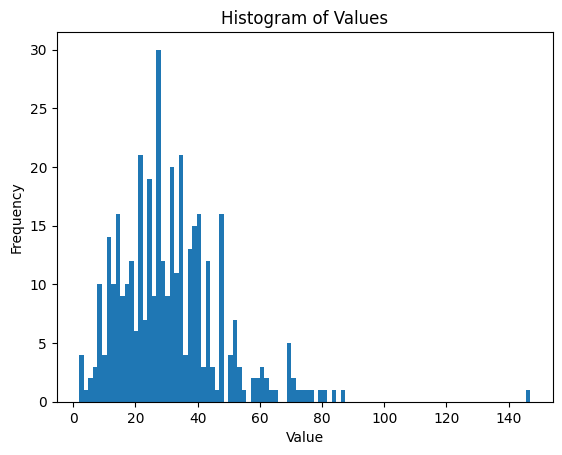

In [5]:
# number of scenes
print('Number of Scenes: ', len(scenes))

total_objects = []
for scan_id in scenes:
    total_objects.append(len(scenes[scan_id]))
print(total_objects)

# Create a histogram
plt.hist(total_objects, bins=100)  # Specify the number of bins or customize as needed

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Display the histogram
plt.show()

## Filtering Scenes

In [17]:
filtered_scenes = {}
for scan_id in scenes:
    
    # Filter out objects with specified labels
    labels_to_remove = ['ceiling', 'wall', 'floor', 'plant', 'window', 'windowsill', 'shades', \
                       'wall frame', 'wall /other room', 'upholstered wall', 'glass wall', 'wall plants', \
                        'slanted wall', 'floor /other room', 'plants', 'doorframe', 'blinds', 'flowers', \
                       'item', 'object', 'items', 'window frame']
    filtered_scenes[scan_id] = [obj for obj in scenes[scan_id] if obj['label'] not in labels_to_remove]
    
    # Filter out objects with problematic dominant normal
    #filtered_scenes[scan_id] = [obj for obj in filtered_scenes[scan_id] if obj['dominantNormal']!=1]
    
    # Filter out objects, if we have too many
    #limit = 20
    #filtered_scenes[scan_id] = filtered_scenes[scan_id][:20]


### Analysis of a single filtered scene

In [51]:
scan_id = '0ad2d3a3-79e2-2212-9a51-9094be707ec2'
#scan_id = '754e884c-ea24-2175-8b34-cead19d4198d'

total_objects = len(filtered_scenes[scan_id])
print("Total objects:", total_objects)
print('---')

# Create an empty dictionary to store label counts
label_counts = {}

# Count the occurrences of each label
for item in filtered_scenes[scan_id]:
    label = item['label']
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

# Print the label counts
for label, count in label_counts.items():
    print(label, count)

Total objects: 9
---
sink 1
stool 1
mirror 1
shower curtain 1
door 1
toilet 1
hair dryer 1
shelf 1
toilet paper dispenser 1


### Plot a single filtered Scene

sink
[1.57079633 0.         1.43561073]
stool
[1.57079633 0.         1.24575173]
mirror
[ 1.57079633e+00 -2.22044605e-16  1.44913485e+00]
shower curtain
[ 1.57079633  0.         -0.12083885]
shower
[ 1.57079633  0.         -0.56037308]
door
[ 1.57079633e+00 -2.22044605e-16  2.15378416e+00]
toilet
[ 1.57079633  0.         -0.25762219]
bucket
[ 1.57079633e+00 -2.22044605e-16  1.52136436e+00]
trash can
[ 1.57079633e+00 -4.44089210e-16  1.06410819e+00]
hair dryer
[ 1.57079633  0.         -0.2447968 ]
shelf
[ 1.57079633e+00 -2.22044605e-16  1.46217619e+00]
toilet paper dispenser
[ 1.57079633e+00 -2.22044605e-16  1.37705435e+00]


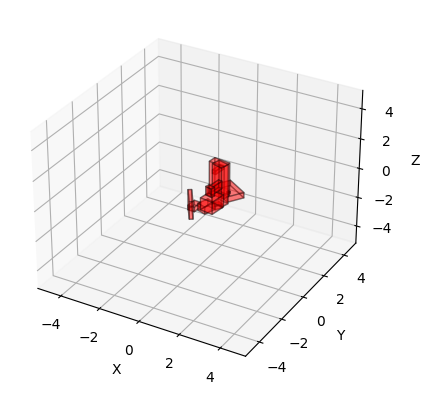

In [46]:
scan_id = '0ad2d3a3-79e2-2212-9a51-9094be707ec2'
#scan_id = '754e884c-ea24-2175-8b34-cead19d4198d'

# Create a 3D plot
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')

# Visualize objects in the scene
for object_data in filtered_scenes[scan_id]:

    # Extract necessary data from the object
    location = object_data['location']
    size = object_data['size']
    euler_angles = object_data['euler_angles']
    
    print(object_data['label'])
    print(object_data['euler_angles'])
    
    rotation = Rotation.from_euler('xyz', euler_angles)
    rotation_matrix = rotation.as_matrix()
        

    # Compute half-lengths along each axis
    half_lengths = np.array(size) / 2

    # Define relative coordinates of object's corners in local frame
    corners = np.array([
        [-1, -1, -1],  # Corner 1
        [-1, -1, 1],   # Corner 2
        [-1, 1, -1],   # Corner 3
        [-1, 1, 1],    # Corner 4
        [1, -1, -1],   # Corner 5
        [1, -1, 1],    # Corner 6
        [1, 1, -1],    # Corner 7
        [1, 1, 1]      # Corner 8
    ])
    scaled_corners = corners * half_lengths
    relative_corners = np.transpose(scaled_corners)

    relative_corners_4 = np.vstack((relative_corners, np.ones(relative_corners.shape[1])))

    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = location

    global_corners_4 = np.matmul(transformation_matrix, relative_corners_4)
    global_corners = np.transpose(global_corners_4[:3, :])
    
    polygons = [
        [global_corners[0], global_corners[1], global_corners[3], global_corners[2]],
        [global_corners[4], global_corners[5], global_corners[7], global_corners[6]],
        [global_corners[0], global_corners[1], global_corners[5], global_corners[4]],
        [global_corners[2], global_corners[3], global_corners[7], global_corners[6]],
        [global_corners[0], global_corners[2], global_corners[6], global_corners[4]],
        [global_corners[1], global_corners[3], global_corners[7], global_corners[5]]
    ]
    
    # Create the 3D collection and add it to the plot
    collection = Poly3DCollection(polygons, alpha=0.3, facecolor='red', edgecolor='black')
    ax.add_collection3d(collection)
    

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits of the plot's axes
factor = 5
x_min, x_max, y_min, y_max, z_min, z_max = -factor, factor, -factor, factor, -factor, factor
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

# Show the plot
plt.show()

## Analysis of all filtered scenes

[28, 12, 32, 23, 3, 12, 18, 9, 9, 43, 42, 17, 15, 25, 31, 13, 23, 33, 29, 44, 7, 20, 19, 37, 33, 12, 19, 4, 21, 8, 23, 13, 39, 31, 26, 26, 33, 34, 27, 29, 18, 5, 19, 45, 4, 28, 26, 18, 39, 6, 12, 29, 29, 15, 25, 18, 26, 40, 6, 26, 22, 7, 22, 13, 5, 16, 29, 20, 12, 23, 17, 21, 11, 8, 44, 33, 10, 18, 12, 29, 12, 31, 11, 9, 21, 17, 9, 19, 9, 8, 30, 27, 6, 7, 19, 25, 11, 25, 1, 49, 22, 66, 33, 9, 22, 41, 24, 11, 17, 31, 31, 18, 27, 18, 14, 24, 22, 11, 27, 28, 5, 23, 21, 38, 34, 17, 10, 31, 8, 14, 30, 9, 15, 22, 19, 20, 16, 16, 34, 18, 10, 27, 36, 26, 13, 16, 20, 18, 63, 23, 15, 33, 32, 4, 51, 6, 25, 25, 30, 25, 28, 42, 22, 24, 35, 33, 6, 9, 12, 25, 13, 17, 39, 19, 9, 18, 10, 11, 47, 19, 19, 9, 14, 36, 18, 29, 14, 4, 2, 28, 16, 18, 35, 27, 10, 27, 8, 23, 6, 31, 19, 10, 13, 27, 16, 15, 48, 8, 15, 24, 6, 11, 5, 5, 38, 25, 5, 27, 29, 7, 22, 8, 17, 23, 27, 25, 57, 54, 22, 37, 18, 22, 34, 3, 21, 11, 10, 12, 7, 11, 22, 10, 6, 21, 32, 14, 2, 20, 11, 29, 15, 7, 1, 14, 31, 27, 15, 26, 26, 21, 18, 27

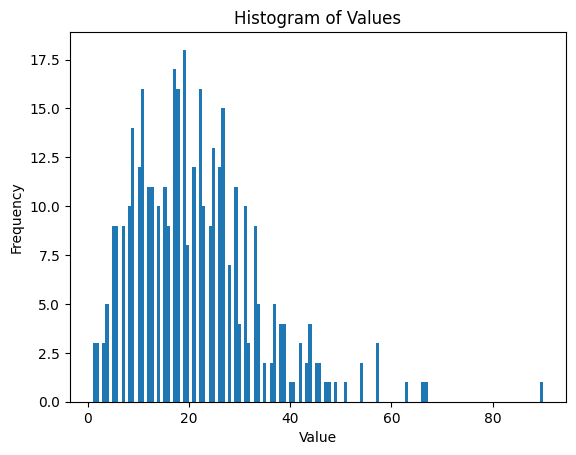

In [18]:
total_objects = []
for scan_id in filtered_scenes:
    total_objects.append(len(filtered_scenes[scan_id]))
print(total_objects)

# Create a histogram
plt.hist(total_objects, bins=140)  # Specify the number of bins or customize as needed

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Display the histogram
plt.show()

Label: chair | Count: 688
Label: pillow | Count: 532
Label: box | Count: 482
Label: shelf | Count: 470
Label: lamp | Count: 298
Label: table | Count: 278
Label: door | Count: 254
Label: curtain | Count: 230
Label: picture | Count: 222
Label: cabinet | Count: 164
Label: bag | Count: 141
Label: light | Count: 131
Label: armchair | Count: 126
Label: clothes | Count: 119
Label: stool | Count: 118
Label: kitchen cabinet | Count: 113
Label: towel | Count: 110
Label: sink | Count: 105
Label: blanket | Count: 97
Label: commode | Count: 94
Label: trash can | Count: 90
Label: heater | Count: 85
Label: wardrobe | Count: 81
Label: bed | Count: 80
Label: bench | Count: 78
Label: desk | Count: 76
Label: sofa | Count: 72
Label: monitor | Count: 69
Label: basket | Count: 67
Label: cushion | Count: 65
Label: tv | Count: 59
Label: nightstand | Count: 56
Label: coffee table | Count: 50
Label: mirror | Count: 45
Label: bath cabinet | Count: 45
Label: rack | Count: 45
Label: toilet | Count: 42
Label: kitch

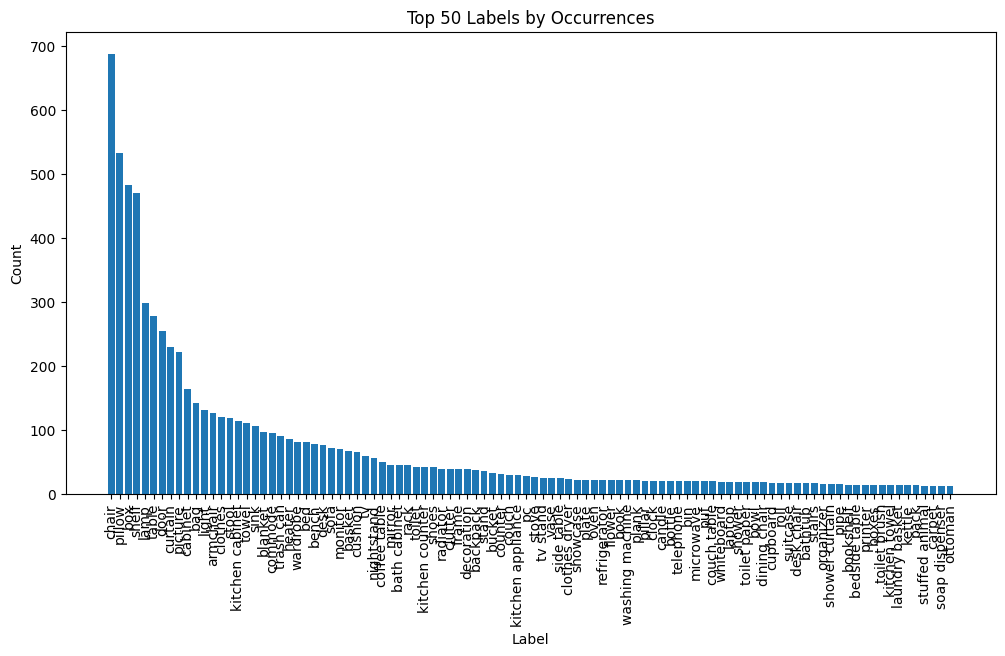

In [26]:
label_counts = Counter()

for scan_id in filtered_scenes:
    seg_groups = filtered_scenes[scan_id]
    for seg_group in seg_groups:
        label = seg_group.get("label")
        if label:
            label_counts[label] += 1
            
# Sort labels by count in descending order
sorted_labels = sorted(label_counts, key=label_counts.get, reverse=True)

# Print all labels and their counts
for label in sorted_labels:
    count = label_counts[label]
    print(f"Label: {label} | Count: {count}")


# Get the top 100 labels with the most occurrences
top_labels = label_counts.most_common(100)
labels, counts = zip(*top_labels)

print(labels)


# Set the figure size
plt.figure(figsize=(12, 6))

# Create a bar chart
plt.bar(labels, counts)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Top 50 Labels by Occurrences")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Create Scene Matrix Data

In [76]:
scene_matrices = {}
for scene_id in filtered_scenes:
    # Extract values from the dataset
    locations = np.array([obj['location'] for obj in filtered_scenes[scene_id]])
    euler_angles = np.array([obj['euler_angles'] for obj in filtered_scenes[scene_id]])
    sizes = np.array([obj['size'] for obj in filtered_scenes[scene_id]])

    # Create the matrix
    stacked_matrix = np.hstack((locations, euler_angles, sizes))
    
    # Determine the desired number of rows
    desired_rows = 20

    # Add rows of zeros to each matrix
    scene_matrices[scene_id] = np.pad(stacked_matrix, [(0, desired_rows - stacked_matrix.shape[0]), (0, 0)], mode='constant')


In [77]:
print(scene_matrices['f4f31600-8408-2255-971c-b8c20605563a'])

[[ 1.26275718e+00  3.51208396e+00 -1.30000078e-01  1.57079633e+00
   0.00000000e+00 -3.41771455e-01  9.91616681e-01  2.71999997e+00
   5.72320205e-01]
 [ 4.87943595e-01  3.53441606e+00 -4.61602562e-01  1.57079633e+00
   0.00000000e+00 -5.44060096e-01  8.70828715e-01  4.96794973e-01
   4.67499190e-01]
 [ 4.08385676e-01  3.50626931e+00 -1.00000003e+00  1.57079633e+00
   0.00000000e+00 -5.51839495e-01  7.83675936e-01  8.59999935e-01
   7.25572164e-01]
 [ 1.12023500e+00  1.62539312e+00 -2.70218065e-01  1.57079633e+00
  -2.22044605e-16  1.26660255e+00  2.56271577e+00  2.27956391e+00
   6.87327407e-01]
 [-1.45828692e+00  3.07396521e-01 -9.31165075e-01  1.57079633e+00
   0.00000000e+00 -3.51407203e-01  1.84269128e+00  9.62330022e-01
   4.68365149e-01]
 [-1.60346762e+00  3.94241420e+00 -1.21937007e+00  1.57079633e+00
  -2.22044605e-16  1.22755206e+00  7.04980628e-01  4.98739947e-01
   3.91488116e-01]
 [-2.56726053e+00  1.58343214e+00 -8.17770072e-01  1.57079633e+00
   0.00000000e+00  1.0113547